# Perceptual Path Length (PPL)

> Evaluate the quality of images generated by GAN

It is a metric introduced as part of StyleGAN to evaluate how well a generator manages to smoothly interpolate between points in its latent space.

If we travel between two images produces by a generator on a straight line in the latent space, PPL measures the expected "jarringness" of each step in the interpolation when you add together the jarringness of each step from random paths.

The StyleGAN2 paper noted that metric also "correlates with consistency and stability of shapes" 

Like FID, PPL uses the feature embeddings of DCNN. The distance between two image embeddings. Unlike in FID, VGG16 net is used instead of InceptionNet

[The Unreasonable Effectiveness of Deep Features as a Perceptual Metric](https://ieeexplore.ieee.org/document/8578166)


-- paper

In [2]:
'''
Evaluating the performance of GAN is challenging 
SSIM - Pixel-wise difference or Structural Similarity Index
SSIM do not always align with human perception or image quality
'''
import lpips # for computing Perceptual similarity between images 
from shutil import copyfile # shutil - for file operations
import os


cache_path = './checkpoints'

vgg_file = ''

if not os.path.exists(f"{cache_path}{vgg_file}"):
    print("Moving file to cache")
    os.makedirs(cache_path, exist_ok=True)
    copyfile(vgg_file, f"{cache_path}{vgg_file}")

loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/jerlshin/env_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jerlshin/env_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/jerlshin/env_ai/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchvision.models as models

class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
       
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)



def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()



In [4]:
z_dim = 64
device = 'cpu'
gen = Generator(z_dim) # initialized with the latent space of z_dim
gen.load_state_dict(torch.load(f'../../C1 Build Basic GAN - 26 hrs/W4 Conditional GAN and Controllable Generation/Model_CGAN/pretrained_celeba.pth', map_location=torch.device(device=device))["gen"])
gen = gen.eval()

In [5]:
vgg16_model = models.vgg16(pretrained=True) # torchvision.models.vgg16(pretrained=True)

## From LPIPS to PPL

StyleGAN does not operate directly on the randomly sampled latent vector. 

It learns a mapping f from z to w, that is $ f(z) = w $

There are two spaces over which you can calculate the PPL - Perceptual Path Length


### Linear Interpolation (w-space)

For the w-space PPL is defined a follows using Linear Interpolation,

First, you sample two points in w-space, $w_1 = f(z_1)$ and $w_2 = f(z_2)$ for two randomly sampled points in z-space. 



In [6]:
map_fn = nn.Identity()
w_1, w_2 = map_fn(torch.randn(1, z_dim)), map_fn(torch.randn(1, z_dim))

Now, we use generator to produce two images interpolating between w1 and w2

The amount of w1 is $t$ <br>
The amount of w2 is $t+\epsilon$

$t$ as a sampling a random point along the path interpolating between w1 and w2

In [7]:
# we use torch.lerp() for linear interpolation, and sample a random t uniformly from 0 to 1 using torch.rand()

'''
Selecting two random points in the latent space and then images corresponding to these points in both the generator and the real data distributed are generated
'''
eps = 2e-1
t = torch.rand(1)
interpolated_1 = torch.lerp(w_1, w_2, t)
interpolated_2 = torch.lerp(w_1, w_2, t + eps)

y_1, y_2 = gen(interpolated_1), gen(interpolated_2)

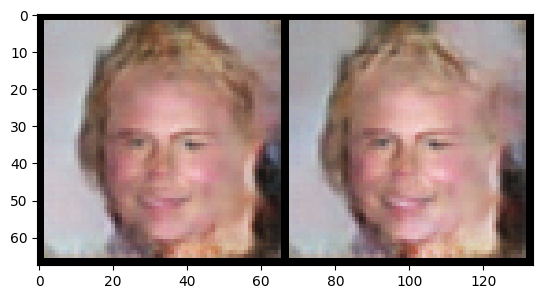

Image LPIPS is 0.08848844468593597


In [8]:
show_tensor_images(torch.cat([y_1, y_2]))
cur_lpips = loss_fn_vgg(y_1, y_2).item() # Learned Perceptual Image Patch Similarity
print(f"Image LPIPS is {cur_lpips}")

In [9]:
ppl = cur_lpips / (eps ** 2) # Perceptual Path Length
print(f"Out final sample PPL is {ppl}")

Out final sample PPL is 2.212211117148399



$$PPL_{w} = \mathbb{E}\left[\frac{1}{\epsilon^2} \mathop{d_{\mathrm{LPIPS}}}\left(\mathop{\mathrm{G}}\left(\mathrm{lerp}(w_1, w_2, t\right), \mathop{\mathrm{G}}\left(\mathrm{lerp}(w_1, w_2, t + \epsilon\right)\right)\right]$$

Expectation as this is repeated many times in order to approximate PPL

In [10]:
def ppl_w(gen, map_fn, num_samples=10, eps=1e-4):
    # sample of a batch of num_samples pairs of points
    w_1 = map_fn(torch.randn(num_samples, z_dim))
    w_2 = map_fn(torch.randn(num_samples, z_dim))
    
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    
    # Interpolate between points
    interpolated_1 = torch.lerp(w_1, w_2, t)
    interpolated_2 = torch.lerp(w_1, w_2, t + eps)

    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)

    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)

    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()



print(f"PPL_w: {ppl_w(gen, nn.Identity()).item()}")

PPL_w: 23.947559356689453


### Spherical Interpolation ($z$-space)

As we sample points in $z$ from a Gaussian, we use spherical interpolation instead of linear interpolation to interpolate in $z$-space. We can use `scipy.spatial.geometric_slerp` for this.

$$slerp(z_1, z_2, t) = \frac{\sin[(1 - t) \cdot \Omega]}{\sin\Omega} z_1 + \frac{\sin[t \cdot \Omega]}{\sin\Omega} z_2$$

where $ \Omega = \cos^{-1}(\mathrm{dot}(\bar{z}_1, \bar{z}_2))$ and $\bar{x}$ denotes the normalized version of x.

In [11]:
def normalize(x):
    return x / torch.norm(x, dim=1)[:, None]

def get_omega(x, y):
    return torch.acos((normalize(x) * normalize(y)).sum(1))

def slerp(x, y, t):
    omega = get_omega(x, y)[:, None]
    c1 = torch.sin(omega * (1 - t)) / torch.sin(omega)
    c2 = torch.sin(omega * t) / torch.sin(omega)
    return c1 * x + c2 * y

def ppl_z(gen, num_samples=10, eps=1e-4):
    # Sample of a batch of num_samples pairs of points
    z_1 = torch.randn(num_samples, z_dim)
    z_2 = torch.randn(num_samples, z_dim)
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = slerp(z_1, z_2, t)
    interpolated_2 = slerp(z_1, z_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_z: {ppl_z(gen).item()}")

PPL_z: 18.39109230041504
